# FX Hedge Cost 10y

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")

hc_path = os.path.join(data_path, "hc.parquet")
eur_path = os.path.join(data_path, "eur_yield.parquet")
jpy_path = os.path.join(data_path, "jpy_yield.parquet")
ust_path = os.path.join(data_path, "tsy_yield.parquet")

# Read in Data

In [3]:
df_eur = (pd.read_parquet(
    path = eur_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "EUR"))

df_jpy = (pd.read_parquet(
    path = jpy_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-3:-1]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "JPY"))

df_us = (pd.read_parquet(
    path = ust_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "USA"))

df_yield = pd.concat([df_eur, df_jpy, df_us])

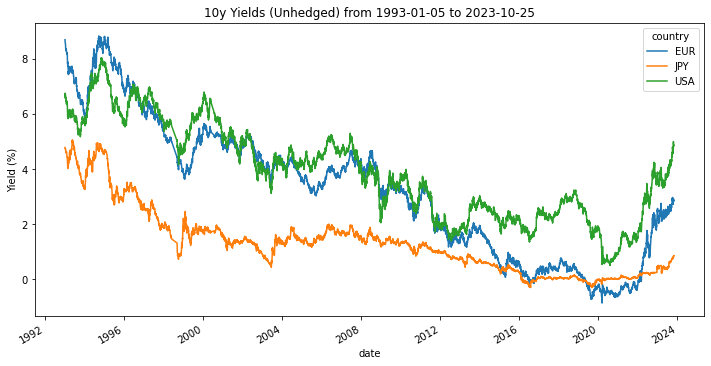

In [4]:
df_plot = (df_yield.pivot(
    index = "date", columns = "country", values = "PX_LAST").
    dropna())

(df_plot.plot(
    figsize = (12,6),
    ylabel = "Yield (%)",
    title = "10y Yields (Unhedged) from {} to {}".format(
        df_plot.index.min().date(),
        df_plot.index.max().date())))

plt.show()

In [5]:
df_hc = (pd.read_parquet(
    path = hc_path, engine = "pyarrow").
    assign(
        security = lambda x: x.security.str.split(" ").str[0],
        country = lambda x: np.where(x.security.str[-3] == "J", "JPY", "EUR")))

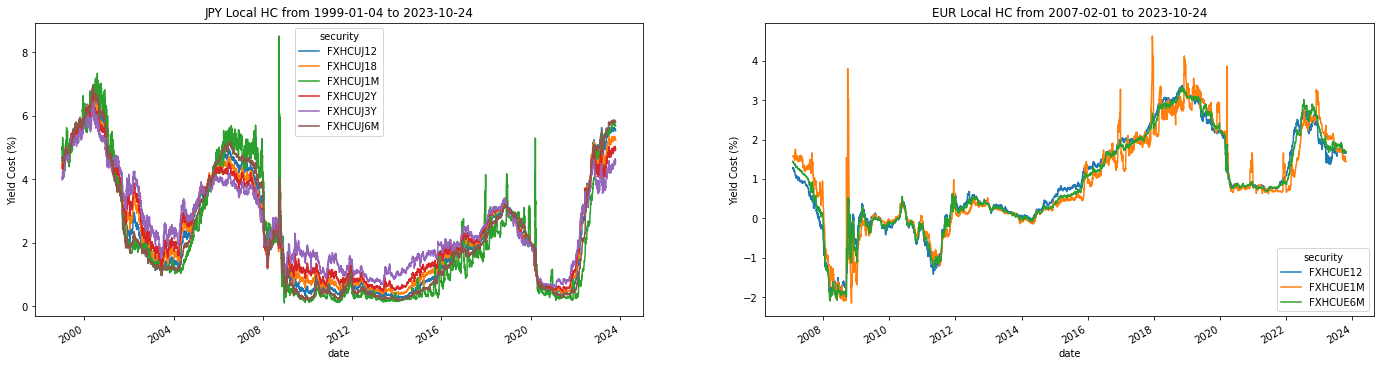

In [6]:
countries = df_hc.country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, figsize = (24,6))

for i, country in enumerate(countries):
    
    df_plot = (df_hc.query(
        "country == @country").
        drop(columns = ["country"]).
        pivot(index = "date", columns = "security", values = "PX_LAST").
        dropna())
    
    (df_plot.plot(
        ax = axes[i],
        ylabel = "Yield Cost (%)",
        title = "{} Local HC from {} to {}".format(
            country,
            df_plot.index.min().date(),
            df_plot.index.max().date())))

# Examining Sample Hedging Costs

In [7]:
df_us = (df_yield.query(
    "country == 'USA'").
    drop(columns = ["country"]).
    rename(columns = {"PX_LAST": "us_yield"}))

df_combined = (df_hc.merge(
    right = df_us, how = "inner", on = "date").
    assign(hedged_rate = lambda x: x.us_yield - x.PX_LAST).
    rename(columns = {"PX_LAST": "hedge_cost"}).
    merge(right = df_yield, how = "inner", on = ["date", "country"]).
    rename(columns = {"PX_LAST": "local_yield"}))

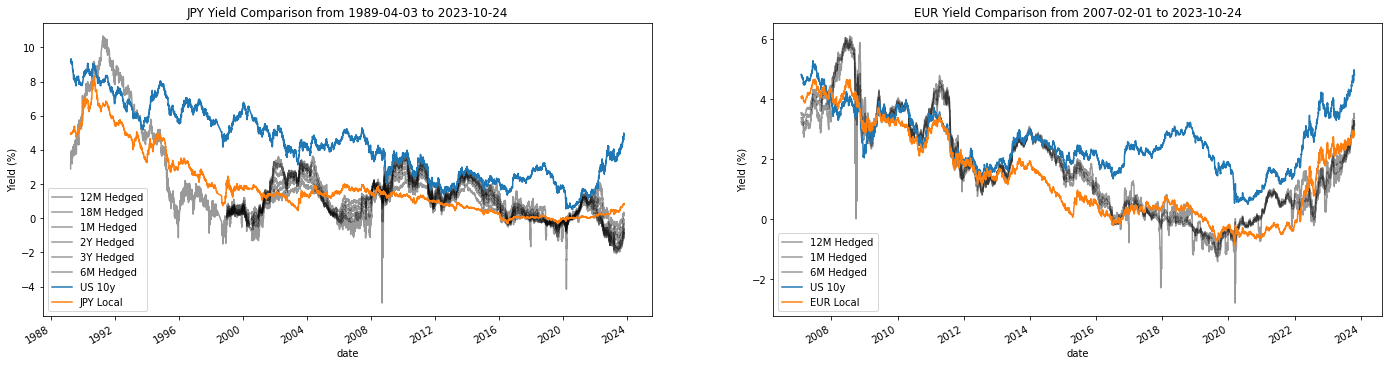

In [8]:
countries = df_combined.country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, figsize = (24,6))

for i, country in enumerate(countries):
    
    df_tmp = df_combined.query("country == @country")
    df_yield_tmp = (df_tmp[
        ["date", "us_yield", "local_yield"]].
        set_index("date").
        drop_duplicates().
        rename(columns = {
            "us_yield": "US 10y",
            "local_yield": "{} Local".format(country)}))
    
    (df_tmp[
        ["date", "security", "hedged_rate"]].
        assign(
            sec_tmp = lambda x: x.security.str[-2:],
            new_name = lambda x: np.where((x.sec_tmp.str[-1] != "M") & (x.sec_tmp.str[-1] != "Y"), x.sec_tmp + "M", x.sec_tmp),
            test = lambda x: x.new_name + " Hedged").
        drop(columns = ["security", "sec_tmp", "new_name"]).
        rename(columns = {"test": "tickers"}).
        pivot(index = "date", columns = "tickers", values = "hedged_rate").
        plot(
            ax = axes[i],
            color = "black",
            alpha = 0.4))
    
    (df_yield_tmp.plot(
        ax = axes[i],
        ylabel = "Yield (%)",
        title = "{} Yield Comparison from {} to {}".format(
            country,
            df_yield_tmp.index.min().date(),
            df_yield_tmp.index.max().date())))

    axes[i].legend(loc = "lower left")

Let's examine the spread between hedged 10yr and the sovereign yield for the international investor

In [9]:
df_spread = (df_combined.assign(
    yield_spread = lambda x: x.hedged_rate - x.local_yield,
    sec_tmp = lambda x: x.security.str[-2:],
    new_name = lambda x: np.where((x.sec_tmp.str[-1] != "M") & (x.sec_tmp.str[-1] != "Y"), x.sec_tmp + "M", x.sec_tmp),
    test = lambda x: x.new_name + " Hedged")
    [["date", "country", "test", "yield_spread"]].
    rename(columns = {"test": "Hedged Rate"}))

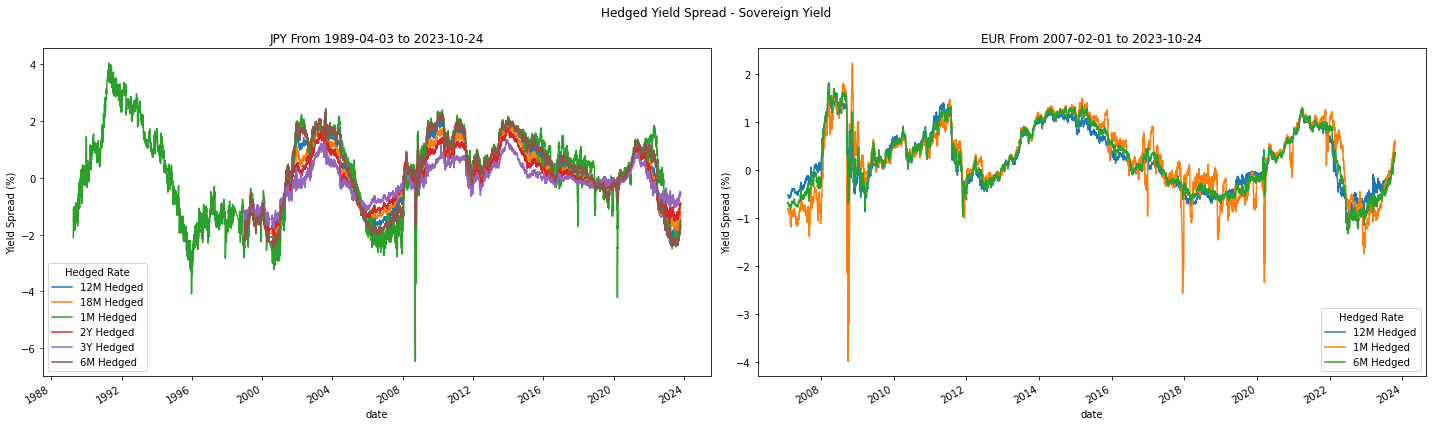

In [10]:
countries = df_spread.country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(countries), figsize = (20,6))

for i, country in enumerate(countries):
    
    df_plot = (df_spread.query(
        "country == @country").
        drop(columns = ["country"]).
        pivot(index = "date", columns = "Hedged Rate", values = "yield_spread"))
    
    (df_plot.plot(
        ax = axes[i],
        ylabel = "Yield Spread (%)",
        title = "{} From {} to {}".format(
            country,
            df_plot.index.min().date(),
            df_plot.index.max().date())))
    
fig.suptitle("Hedged Yield Spread - Sovereign Yield")
plt.tight_layout()
plt.show()

# Caveats and Consideration

Since this work was prompted by the recent changes in the BOJ ultra-monetary policy response and hedge rate as well as the changes in supply/demand dynamics in UST market from a monetary standpoint but also a safe-haven asset due to geopolitical turmoial, in theory there is look-ahead bias. 

# Testing

1. Are foreign investors going in unhedged
2. Is there are relationship between Treasury Holdings by sovereign and unhedged rate and rate differential
3. Is there are relationship between Treasury Holdings and foreign exchange rate

## Are foreign investors going in unhedged

In [11]:
hold_path = os.path.join(data_path, "tsy_holders.parquet")
df_holder_raw = (pd.read_parquet(
    path = hold_path, engine = "pyarrow"))

jpy_sec = "HOLDJN Index"

df_holder_jpy = df_holder_raw.query("security == @jpy_sec")
df_holder_eur = (df_holder_raw.query(
    "security != @jpy_sec").
    pivot(index = "date", columns = "security", values = "PX_LAST").
    sum(axis = 1).
    to_frame().
    rename(columns = {0: "EUR"}))

df_holder = (df_holder_jpy.drop(
    columns = ["security"]).
    rename(columns = {"PX_LAST": "JPY"}).
    merge(right = df_holder_eur, how = "inner", on = ["date"]).
    set_index("date"))

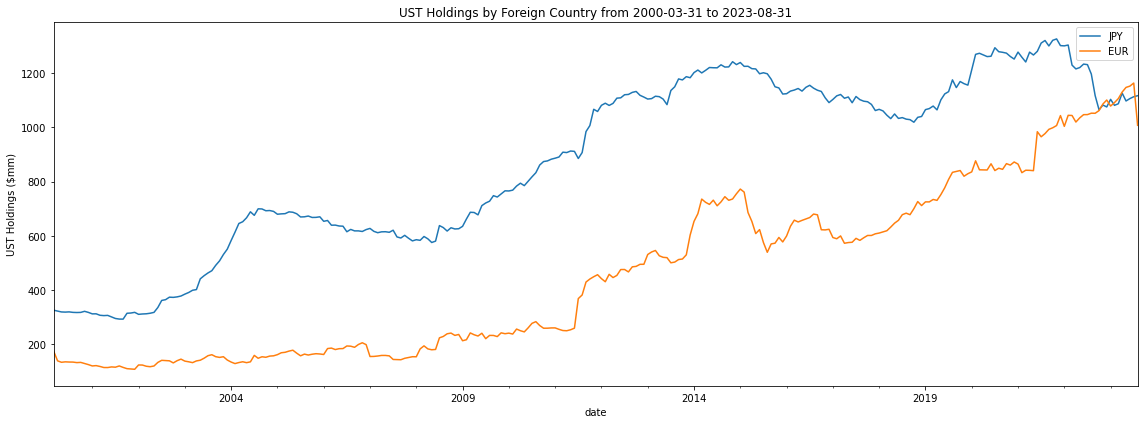

In [12]:
df_holder.plot(
    ylabel = "UST Holdings ($mm)",
    figsize = (16,6),
    title = "UST Holdings by Foreign Country from {} to {}".format(
        df_holder.index.min().date(),
        df_holder.index.max().date()))

plt.tight_layout()
plt.show()

In [13]:
df_combined = (df_holder.pct_change().reset_index().melt(
    id_vars = "date", value_name = "holding", var_name = "country").
    dropna().
    assign(month_year = lambda x: x.date.dt.month.astype(str) + "_" + x.date.dt.year.astype(str)).
    merge(
        right = (df_spread.assign(
            month_year = lambda x: x.date.dt.month.astype(str) + "_" + x.date.dt.year.astype(str)).
            set_index("date").
            resample("M").
            last().
            reset_index(drop = True)),
        how = "inner",
        on = ["month_year", "country"]).
    drop(columns = ["month_year"]).
    rename(columns = {"Hedged Rate": "hedge_rate"}).
    assign(holding = lambda x: x.holding * 100))

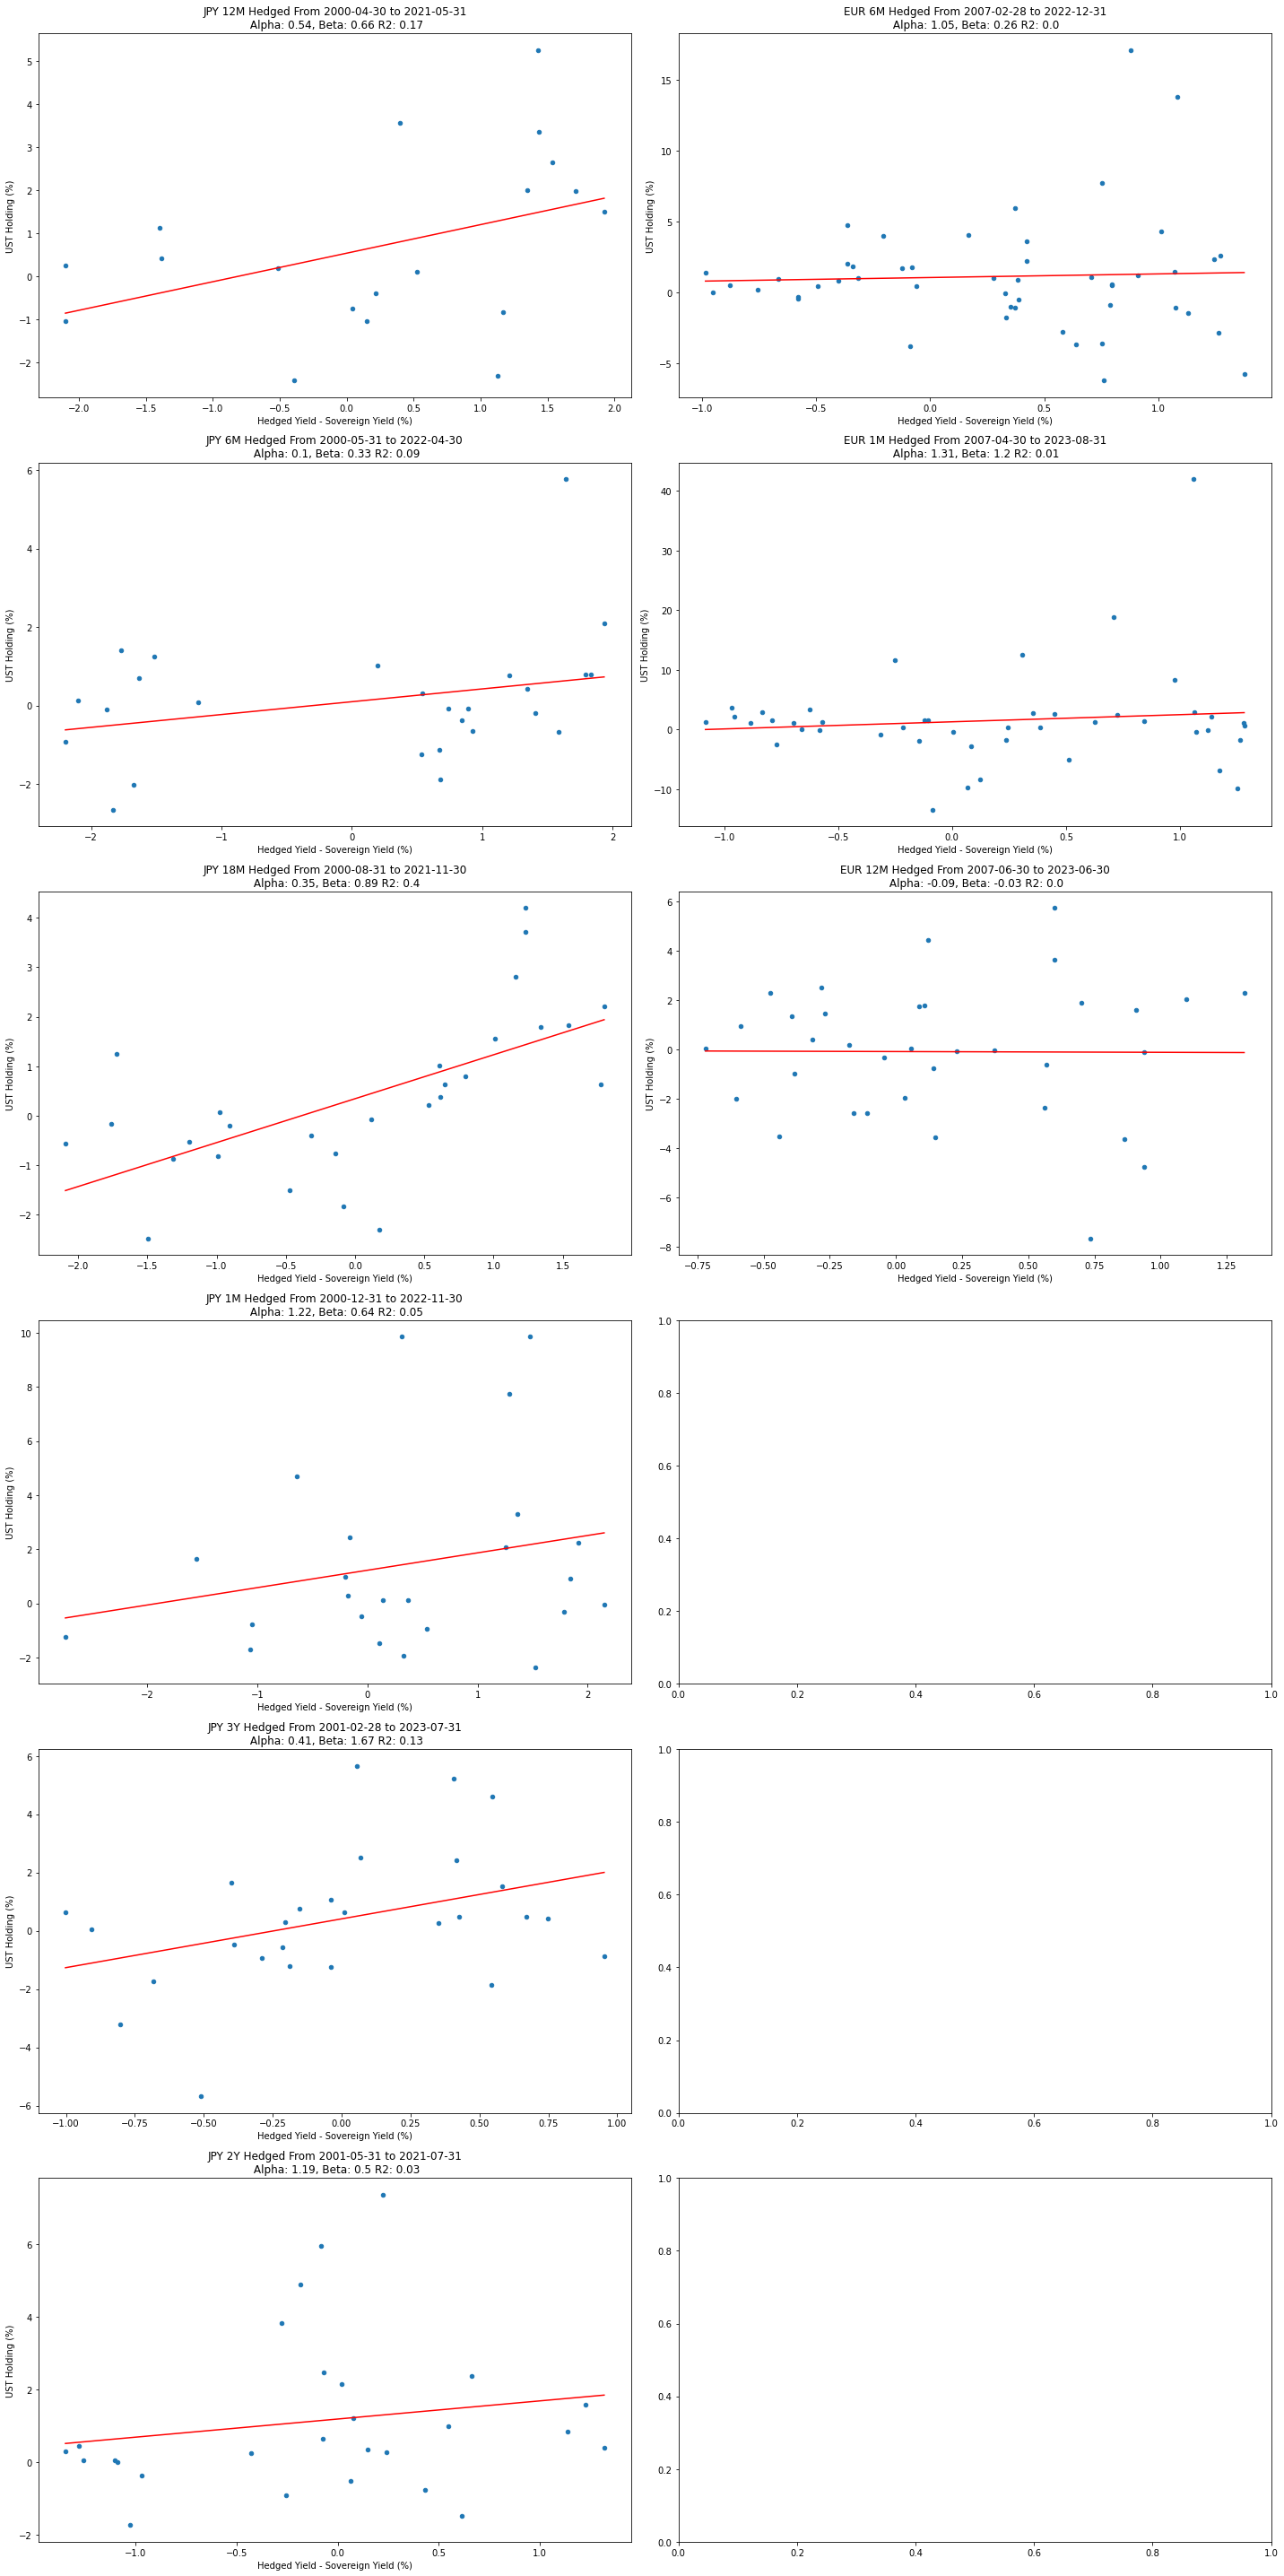

In [14]:
countries = df_combined.country.drop_duplicates().to_list()
fig, axes = plt.subplots(
    ncols = len(countries), 
    nrows = df_combined[["country", "hedge_rate"]].drop_duplicates().groupby("country").agg("count")["hedge_rate"].max(),
    figsize = (20,40))

for i, country in enumerate(countries):
    for j, hedge_rate in enumerate(df_combined.query("country == @country").hedge_rate.drop_duplicates().to_list()):
        
        df_scatter = df_combined.query("country == @country & hedge_rate == @hedge_rate")
        regression = (sm.OLS(
            endog = df_scatter["holding"],
            exog = sm.add_constant(df_scatter["yield_spread"])).
            fit())
        
        alpha, beta = regression.params
        rsquared = regression.rsquared
        
        (df_scatter.plot(
            ax = axes[j,i],
            kind = "scatter",
            x = "yield_spread",
            y = "holding",
            xlabel = "Hedged Yield - Sovereign Yield (%)",
            ylabel = "UST Holding (%)",
            title = "{} {} From {} to {}\n Alpha: {}, Beta: {} R2: {}".format(
                country, 
                hedge_rate,
                df_scatter.date.min().date(),
                df_scatter.date.max().date(),
                round(alpha, 2),
                round(beta, 2),
                round(rsquared, 2))))
        
        x = np.linspace(
            start = df_scatter["yield_spread"].min(),
            stop = df_scatter["yield_spread"].max(),
            num = 1_000)
        y = (x * beta) + alpha
        axes[j,i].plot(x,y, color = "r")
        
plt.tight_layout()

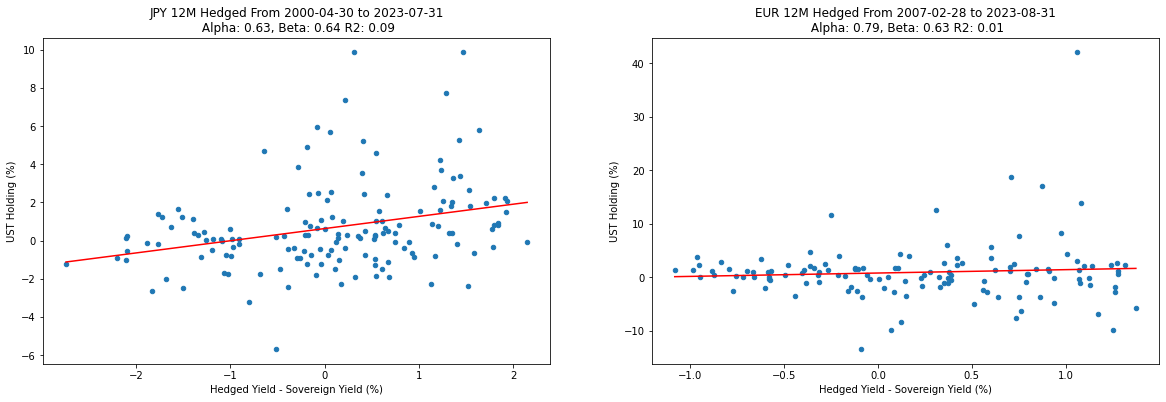

In [15]:
fig, axes = plt.subplots(ncols = len(countries), figsize = (20,6))
for i, country in enumerate(countries):
    
    df_scatter = df_combined.query("country == @country")
    regression = (sm.OLS(
        endog = df_scatter["holding"],
        exog = sm.add_constant(df_scatter["yield_spread"])).
        fit())

    alpha, beta = regression.params
    rsquared = regression.rsquared

    (df_scatter.plot(
        ax = axes[i],
        kind = "scatter",
        x = "yield_spread",
        y = "holding",
        xlabel = "Hedged Yield - Sovereign Yield (%)",
        ylabel = "UST Holding (%)",
        title = "{} {} From {} to {}\n Alpha: {}, Beta: {} R2: {}".format(
            country, 
            hedge_rate,
            df_scatter.date.min().date(),
            df_scatter.date.max().date(),
            round(alpha, 2),
            round(beta, 2),
            round(rsquared, 2))))

    x = np.linspace(
        start = df_scatter["yield_spread"].min(),
        stop = df_scatter["yield_spread"].max(),
        num = 1_000)
    y = (x * beta) + alpha
    axes[i].plot(x,y, color = "r")

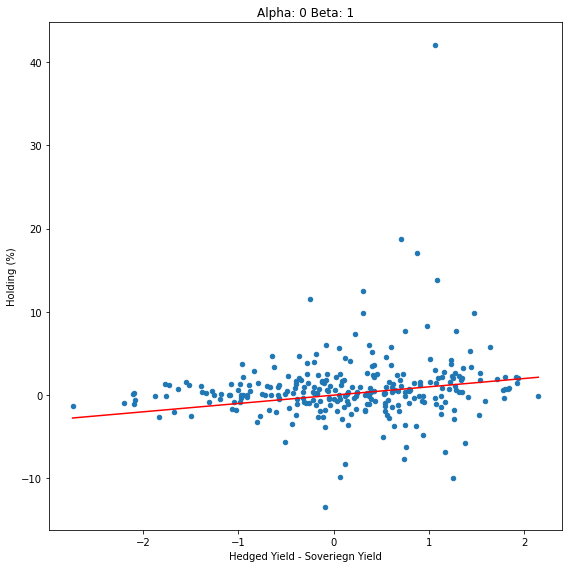

In [16]:
regression = (sm.OLS(
    exog = df_combined["holding"],
    endog = sm.add_constant(df_combined["yield_spread"])).
    fit())

alpha, beta = regression.params
fig, axes = plt.subplots(figsize = (8,8))
(df_combined.plot(
    ax = axes,
    kind = "scatter",
    x = "yield_spread",
    y = "holding",
    xlabel = "Hedged Yield - Soveriegn Yield",
    ylabel = "Holding (%)",
    title = "Alpha: {} Beta: {}".format(
        round(alpha, 2),
        round(beta, 2))))

x = np.linspace(
    start = df_combined["yield_spread"].min(),
    stop = df_combined["yield_spread"].max(),
    num = 1_000)
y = (x * beta) + alpha
axes.plot(x,y, color = "r")

plt.tight_layout()
plt.show()